<a href="https://colab.research.google.com/github/palit-ishan/IE_7374_Project/blob/master/ML_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv
Saving bank-additional.csv to bank-additional.csv
Saving bank-full.csv to bank-full.csv
Saving bank.csv to bank.csv


In [200]:
import pandas as pd
df_bank_full = pd.read_csv('bank-full.csv',sep = ';')

In [201]:
df_bank_full.shape

(45211, 17)

Input variables:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21. y. has the client subscribed a term deposit? (binary: 'yes','no')

According to the dataset documentation, we need to remove the 'duration' column because in real-case the duration is only known after the label column is known. This problem can be considered to be 'data leakage' where predictors include data that will not be available at the time you make predictions.


In [202]:
# Checking null values in dataset
df_bank_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No Null Values are there in the dataset


In [203]:
# Drop 'duration' column
df_bank_full = df_bank_full.drop('duration', axis=1)

Dropping the duration field as the duration will only be recorded after the completion of the marketing call


In [204]:
# Splitting the full data into test and train data to avoid inherent biases in models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_bank_full.iloc[:,0:-1],df_bank_full.iloc[:,-1] , test_size=0.2, random_state=42)

In [205]:
# A merged dataframe of the train set - input and output & test set - input and output 
df_bank_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
df_bank_test = pd.merge(X_test,y_test,left_index = True, right_index = True)

We will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*



In [206]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_bank_ready_train = df_bank_train.copy()
df_bank_ready_test = df_bank_test.copy()

scaler = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
df_bank_ready_train[num_cols] = scaler.fit_transform(df_bank_ready_train[num_cols])
# Using same scaler to transform the test set
df_bank_ready_test[num_cols] = scaler.transform(df_bank_ready_test[num_cols])
df_bank_ready_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,1.703422,jul,-0.245389,-0.411364,-0.244772,unknown,no
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,1.823532,jul,0.395606,-0.411364,-0.244772,unknown,no
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,-0.578656,jun,2.639088,-0.411364,-0.244772,unknown,no
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,-0.098218,apr,-0.245389,-0.411364,-0.244772,unknown,yes


In [207]:
# Renaming output column to 'deposit'
df_bank_ready_train = df_bank_ready_train.rename(columns = {'y':'deposit'})
df_bank_ready_test = df_bank_ready_test.rename(columns = {'y':'deposit'})


In [208]:
df_bank_ready_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,1.703422,jul,-0.245389,-0.411364,-0.244772,unknown,no
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,1.823532,jul,0.395606,-0.411364,-0.244772,unknown,no
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,-0.578656,jun,2.639088,-0.411364,-0.244772,unknown,no
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,-0.098218,apr,-0.245389,-0.411364,-0.244772,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.289048,housemaid,single,primary,no,-0.099915,no,no,unknown,0.262110,jun,-0.565886,-0.411364,-0.244772,unknown,yes
44732,-1.688684,student,single,tertiary,no,-0.282181,no,no,cellular,-0.938984,sep,-0.565886,0.517649,0.177056,failure,no
38158,-0.652729,technician,divorced,tertiary,no,-0.014570,yes,no,cellular,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,no
860,-0.746907,retired,married,secondary,no,-0.395643,no,no,unknown,-1.059093,may,-0.565886,-0.411364,-0.244772,unknown,no


In [209]:
df_bank_ready_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit'],
      dtype='object')

In [211]:
# There is class imbalance in the dataset - the number of no's are almost 8x the number of yes
y_train.value_counts()

no     31970
yes     4198
Name: y, dtype: int64

Text(0, 0.5, 'Class')

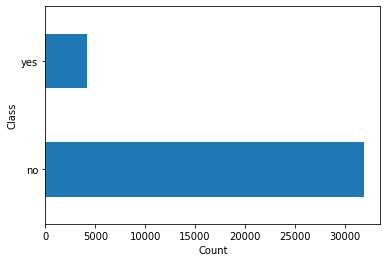

In [146]:
# Plotting Bar Charts for Yes/No counts 
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Class')

Conclusion - Our dataset is highly imbalanced towards No
From a general idea about marketing campaigns we can state that - a customer will be more likely to say No to the term deposit call



In [212]:
#Analysing Job categories
X_train['job'].value_counts()

blue-collar      7806
management       7500
technician       6096
admin.           4137
services         3350
retired          1815
self-employed    1286
entrepreneur     1178
unemployed       1023
housemaid        1002
student           742
unknown           233
Name: job, dtype: int64

Text(0, 0.5, 'Job')

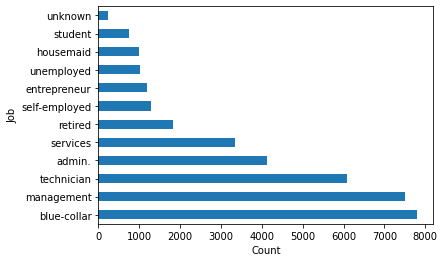

In [213]:
#Analysing Job categories
X_train['job'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Job')

Text(0, 0.5, 'Marital')

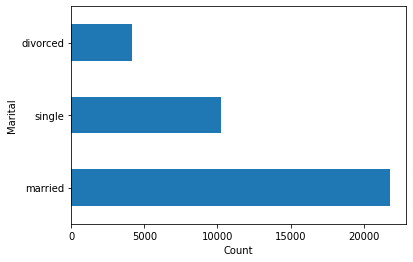

In [214]:
#Analysing Marital categories
X_train['marital'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Marital')

Text(0, 0.5, 'Education')

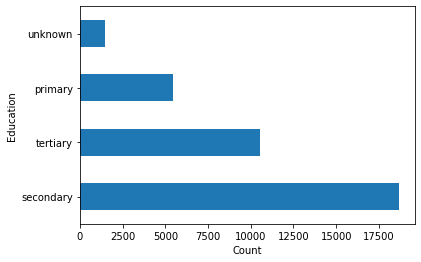

In [215]:
#Analysing education categories
X_train['education'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Education')

Text(0, 0.5, 'Outcome of the previous marketing campaign')

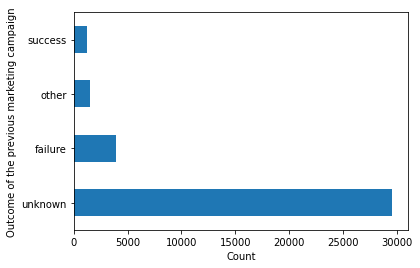

In [216]:
#Analysing Outcome of the previous marketing campaign  categories
X_train['poutcome'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Outcome of the previous marketing campaign')

Text(0.5, 0, 'y: target variable')

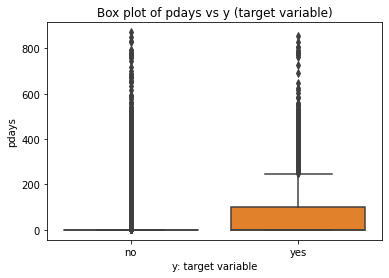

In [217]:
# Analysing p days
import seaborn as sns
sns.boxplot(y=X_train['pdays'], x=y_train)
plt.title('Box plot of pdays vs y (target variable)')
plt.xlabel('y: target variable')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF of pdays for target variable y')

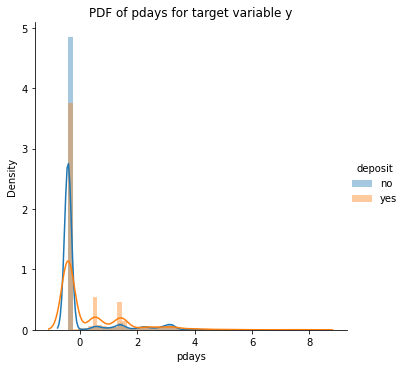

In [219]:
# PDF of pdays for the target variable - y
sns.FacetGrid(df_bank_ready_train, hue='deposit', size=5).map(sns.distplot, 'pdays').add_legend()
plt.title('PDF of pdays for target variable y')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13b3811b10>,
      dtype=object)

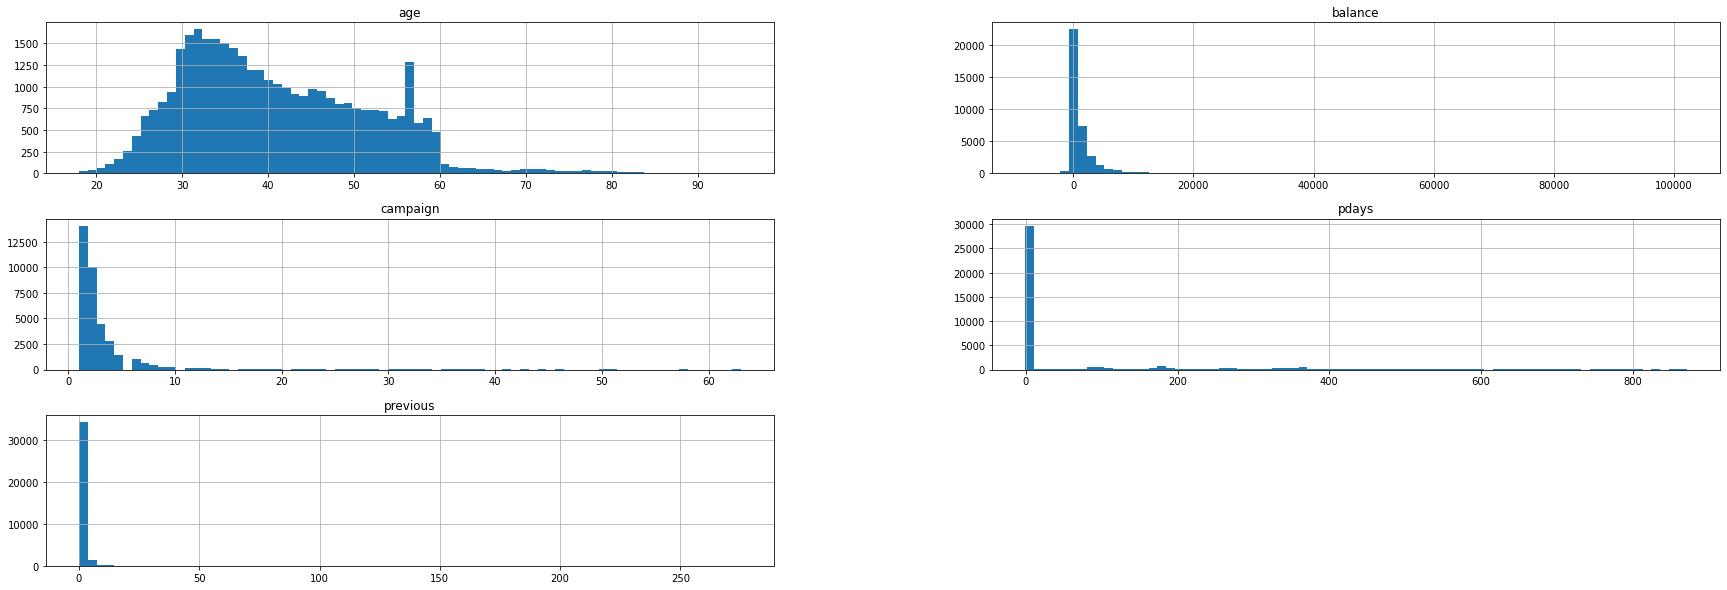

In [152]:
# Univariate Analysis
X_train.hist(column = ['age','balance','campaign','pdays','previous'],figsize = (30,10),bins = 75)

## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...into something like this...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |

In this code cell we will also encode our label column by replacing 'yes' and 'no' with 1 and 0 respectively. We can do this by applying simple lambda/in-line function on the column.


In [153]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded_train = pd.DataFrame(encoder.fit_transform(df_bank_ready_train[cat_cols]))
df_encoded_test = pd.DataFrame(encoder.fit_transform(df_bank_ready_test[cat_cols]))
df_encoded_train.columns = encoder.get_feature_names(cat_cols)
df_encoded_test.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready_train = df_bank_ready_train.drop(cat_cols ,axis=1)
df_bank_ready_train = df_bank_ready_train.reset_index(drop = True)
df_bank_ready_train = pd.concat([df_encoded_train, df_bank_ready_train], axis=1)
df_bank_ready_test = df_bank_ready_test.drop(cat_cols ,axis=1)
df_bank_ready_test = df_bank_ready_test.reset_index(drop = True)
df_bank_ready_test = pd.concat([df_encoded_test, df_bank_ready_test], axis=1)


# Encode target value
df_bank_ready_train['deposit'] = df_bank_ready_train['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_bank_ready_test['deposit'] = df_bank_ready_test['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
print('Shape of train dataframe:', df_bank_ready_train.shape)
print('Shape of test datframe:',df_bank_ready_test.shape)
df_bank_ready_train.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Shape of train dataframe: (36168, 51)
Shape of test datframe: (9043, 51)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.006515,-0.169381,-0.098218,-0.565886,-0.411364,-0.244772,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.759937,0.017848,1.703422,-0.245389,-0.411364,-0.244772,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.100693,0.820681,1.823532,0.395606,-0.411364,-0.244772,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.370196,-0.489588,-0.578656,2.639088,-0.411364,-0.244772,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.419181,0.706889,-0.098218,-0.245389,-0.411364,-0.244772,1


In [182]:
# Feature Selection and Engineering

df_bank_ready_train.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age', 'balance', 'day', 'campaign', 'pdays',
       'previous', 'deposit'],
      dtype='object')

As seen above the number of features of test and train set after encoding is the same at - 51

# Evaluation Metrics

To evaluate our model we will use the confusion matrix as our base for the evaluation.

<div align='center'><img src='https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png' height='250'></div>
where: TP = True Positive; FP = False Positive; TN = True Negative; FN = False Negative.

We will use 6 metrics below to evaluate models:

1. Accuracy: the proportion of true results among the total number of cases examined.
<div align='center'>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$</div>
2. Precision: used to calculate how much proportion of all data that was predicted positive **was** actually positive.
<div align='center'>$Precision = \frac{TP}{TP+FP}$</div>
3. Recall: used to calculate how much proportion of actual positives is correctly classified.
<div align='center'>$Recall = \frac{TP}{TP+FN}$</div>
4. F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall.
<div align='center'>$F1 = \frac{2TP}{2TP+FP+FN}$</div>
5. Cohen Kappa Score: Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.
<div align='center'>$\kappa = \frac{p_o-p_e}{1-p_e}$</div>
    where $p_o$ is the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio), and $p_e$ is the expected agreement when both annotators assign labels randomly. $p_e$ is estimated using a per-annotator empirical prior over the class labels.
6. Area Under Curve (AUC): indicates how well the probabilities from the positive classes are separated from the negative classes

In this case we want to focus on the recall value of our model because in our problem we should try to predict as many actual positive as we can. Because a misclassification of customer who **actually** wanted to make a deposit can mean a lose opportunity/revenue.

Below we will define a helper function to evaluate each trained model and with the metrics mentioned above and save the score to a variable.

In [154]:
class Model_Evaluation:
  def __init__ (self, model, X_test, y_test):
        self.model= model
        self.X_test = X_test
        self.y_test = y_test
  def model_evaluation(self,model,X_test, y_test):
    from sklearn import metrics
    # Predict Test Data 
    y_pred = model.predict(X_test)
    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
  #  y_pred_proba = model.predict_proba(y_test,y_pred)
  #  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
  #  auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return format({'acc': acc, 'prec': prec, 
            'rec': rec, 'f1': f1, 
            'kappa': kappa,'cm': cm})

### Logistic Regression Classifier 



In logistic regression we are performing linear regression but applying a sigmoid function for the outcome.

#### Sigmoid  / Logistic Function

$p =1 / 1 + e^{-y}$

#### Properties of Logistic Regression

* The dependent variable follows a Bernoulli Distribution
* Estimation is maximum likelihood estimation (MLE)

#### Advantages
* Straight forward, easy to implement, doesn't require high compute power, easy to interpret, used widely. 
* Doesn't require feature scaling and provides a probability score for observations.

#### Disadvantages
* Not able to handle a large number of category features/variables. 
* Vulnerable to overfitting. 

In [169]:
# Logistic Regression
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

class LogisticRegression:
    
    def __init__ (self, train_df,test_df,learningRate,tolerance,maxIteration=1000):
        self.learningRate=learningRate
        self.tolerance=tolerance
        self.maxIteration=maxIteration
        self.train_df = train_df
        self.test_df = test_df
        
    def datasetReader(self):
        train_df,test_df=np.array(self.train_df,dtype=np.float64),np.array(self.test_df,dtype=np.float64)
        self.X_train,self.y_train= train_df[:, :-1],train_df[:, -1]
        self.X_test,self.y_test= test_df[:, :-1],test_df[:, -1]
        return self.X_train,self.y_train,self.X_test,self.y_test
    
    
    def addX0(self,X):
        
        return np.column_stack([np.ones(X.shape[0],1),X])
    
    def sigmoid(self,z):
        sig=1/(1+np.exp(-z))
        return sig
    
    def costFunction(self,X,y,i):
        sig = self.sigmoid(X.dot(self.w))
        #Approach 1
        if i == 1:
            cost = (y * np.log(sig) + (1-y)*np.log(1-sig)).sum()
            cost = -cost/X.shape[0]
            
        #Approach 2
        else:
        
            cost = (np.log(np.ones(X.shape[0])+ np.exp(X.dot(self.w)) - 
                         X.dot(self.w).dot(y)))
            cost = cost.sum()
        
        return cost
    
    def gradient(self,X,y):
        sig=self.sigmoid(X.dot(self.w))
        grad=(sig-y).dot(X)
        return grad   # We get gradient per column
    
    def gradientDescent(self,X,y):
        
        cost_sequences=[]
        last_cost=float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            self.w=self.w-self.learningRate* self.gradient(X,y)
            cur_cost=self.costFunction(X,y,2)
            diff=last_cost - cur_cost
            
            last_cost=cur_cost
            cost_sequences.append(cur_cost)
            
            if diff<self.tolerance:
                print("The model stoppped learning")
                break
                
        return
    
    def predict(self,X):
        sig=self.sigmoid(X.dot(self.w))
        return np.around(sig) # if above 0.5 then 1 else 0
    
    def evaluate(self,y,y_hat):
        y=(y==1)
        y_hat=(y_hat == 1)
        accuracy =(y == y_hat).sum() / y.size
        precision=(y & y_hat).sum()/y_hat.sum() # Total postive vs total
        recall=(y & y_hat).sum() / y.sum()
        return accuracy, precision,recall
    
    def fit(self):
        self.X_train,self.y_train,self.X_test,self.y_test= self.datasetReader()
        print("Solving using gradient descent")
        self.w=np.ones(self.X_train.shape[1],dtype =np.float64) * 0
        self.gradientDescent(self.X_train,self.y_train)
        print(self.w)
        y_hat_train=self.predict(self.X_train)
        accuracy,precision,recall =self.evaluate(self.y_train,y_hat_train)
        print("Evaluation for training data: \n")
        print("Accuracy:",accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        y_hat_test = self.predict(self.X_test)
        accuracy,precision,recall = self.evaluate(self.y_test,y_hat_test)
        print("\nEvaluation for test data: \n")
        print("Accuracy:",accuracy)
        print("Precision:", precision)
        print("Recall:", recall)



In [180]:
lr=LogisticRegression(train_df = df_bank_ready_train, test_df = df_bank_ready_test,tolerance=0.0,learningRate=0.01,maxIteration=10000000)
lr.fit()

Solving using gradient descent


  0%|          | 0/10000000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
  0%|          | 1/10000000 [00:00<130:44:50, 21.25it/s]

The model stoppped learning
[-10.765      -27.75        -3.85        -3.13       -17.19
  -0.995       -3.27       -10.67         0.43       -17.22
  -1.835       -0.645      -10.795      -65.17       -20.925
 -17.92       -54.03       -21.305       -3.635      -94.325
  -2.565      -26.805      -70.085      -75.575      -21.315
 -47.75        -5.235      -43.905       -2.22       -13.81
   0.785       -3.95        -3.435      -17.505      -13.05
   1.99       -40.515       -9.425        2.245        2.
  -9.605       -2.395        9.47       -94.36         6.18346647
  12.17100306  -5.98135368 -16.81209206  24.4780223   20.17046113]
Evaluation for training data: 

Accuracy: 0.8837370050873701
Precision: 0.23076923076923078
Recall: 0.0007146260123868509

Evaluation for test data: 

Accuracy: 0.8794647793873714
Precision: 1.0
Recall: 0.0009165902841429881


In [157]:
dtc_eval = Model_Evaluation(lr,X_test = df_bank_ready_test.iloc[:, :-1],y_test = df_bank_ready_test.iloc[:, -1])

In [158]:
dtc_eval.model_evaluation(lr,X_test = df_bank_ready_test.iloc[:, :-1],y_test = df_bank_ready_test.iloc[:, -1])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


"{'acc': 0.8255003870396992, 'prec': 0.33218470020675395, 'rec': 0.44179651695692024, 'f1': 0.3792289535798584, 'kappa': 0.28007200766208984, 'cm': array([[6983,  969],\n       [ 609,  482]])}"